## Simulation code

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random as rnd
from tqdm import tqdm

class DBM_cube:

    def __init__(self,
                 N = 40,
                 dimensions=None,
                 nu=1.5,
                 debug=False,
                 threshold = 0.0001):

        # Unless specified, expect grid of NxNxN dimension, in order z, x, y
        if dimensions is None:
            self.dim = {'height': N, 'width': N,'depth': N}
        else:
            self.dim = {'height': dimensions[0], 'width': dimensions[1],'depth': dimensions[2]}

        # Create encoding grid and set all to 0
        #  0 encodes unfixed potential
        #  anything else encodes fixed potential
        # (I also use this grid to track order of cells in lightning structure)
        self.fixed_grid = np.zeros(shape=list(self.dim.values()))

        # Set all boundaries of box to be fixed
        self.fixed_grid[:, :, 0] = -1  # front boundary
        self.fixed_grid[:, :, -1] = -1  # back boundary
        self.fixed_grid[:, 0, :] = -1  # left boundary
        self.fixed_grid[:, -1, :] = -1  # right boundary
        self.fixed_grid[0, :, :] = -1  # top boundary
        self.fixed_grid[-1, :, :] = -1  # bottom boundary

        # The electric potential
        self.potential = np.zeros(shape=list(self.dim.values()))

        # The lightning downwards-tendency parameter
        self.nu = nu

        # Number of update steps
        self.steps = 1

        # To debug or not
        self.debug = debug

        # Keep track of current neighbors of structure
        self.structure_neighbors = set()

        self.struck_ground = False

        self.threshold = threshold

        # Debugging lists
        self.difference_per_conv = []
        self.overall_sum = []

        self.structure_history = []

        # Neighborhood
        self.neighbors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), 
                         (-1, 0, 0), (0,-1, 0), (0, 0,-1)]
        
        # Setup initial electric potential
        self.initial_electric_pot()

        # Add the first cell as a structure neighbor
        self.structure_neighbors.add((0, self.dim['width']//2, self.dim['depth']//2))
        # Update structure with that cell
        self.expand_lightning_to((0, self.dim['width']//2, self.dim['depth']//2))

        self.steps += 1
        
    def initial_electric_pot(self):
        '''Set the entire box to be a gradient from 1 to 0, bottom to up'''

        # Create a linear gradient along the depth axis
        gradient = np.linspace(0, 1, self.dim['height'])[:, np.newaxis, np.newaxis]

        # Apply the gradient to the array
        self.potential += gradient



    def strike_lightning(self):
        '''Run the simulation until lightning strikes ground'''

        # Run update until lightning strikes ground
        self.struck_ground = False

        # Create a tqdm tracker
        if self.debug:
            progress_bar = tqdm(total=self.dim['height'], desc="How close the lightning is to the ground", unit="iter")

        while not self.struck_ground:
            # Update lightning
            self.update()

            if self.debug:
                # If the newly added cell made the lightning stretch one step lower, update dist_to_ground
                if self.dim['height'] - self.newest_neighbor[0] < self.dist_to_ground:
                    self.dist_to_ground = self.dim['height'] - self.newest_neighbor[0]
                    progress_bar.update(1)

    def update(self):
        '''Choose a new structure neighbor to add to the structure, recalculate electric potential'''
        
        # Calculate probability of selection for structure neighbors
        weights = []
        # For each structure neighbor
        for neighbor_pos in self.structure_neighbors:
            # Raise each weight to the power of nu
            weights.append(self.potential[neighbor_pos[0], neighbor_pos[1], neighbor_pos[2]] ** self.nu)
        
        # Choose a random neighbor with the weighting
        chosen_cell = rnd.choices(list(self.structure_neighbors), weights)[0]

        # Update lightning grid, potential and newest neighbor
        self.expand_lightning_to(chosen_cell)

        self.steps += 1


    def expand_lightning_to(self, pos):
        '''
        Updates correpsonding grids
        Update neighborhood of lightning structure
        Call method to update electric potential
        '''

        self.newest_neighbor = pos

        self.structure_history.append(pos)

        # Remove the potential
        self.potential[pos[0], pos[1], pos[2]] = 0

        # Set it as a fixed cell
        self.fixed_grid[pos[0], pos[1], pos[2]] = self.steps

        # Update structure neighbors
        self.structure_neighbors.remove(pos)
        for neighbor_delta in self.neighbors:
            neighbor_pos = (pos[0] + neighbor_delta[0], pos[1] + neighbor_delta[1], pos[2] + neighbor_delta[2])
            if neighbor_pos[0] == self.dim['height']:
                self.struck_ground = True
                break

            if neighbor_pos[0] >= 0 and neighbor_pos[0] < self.dim['height'] and \
                neighbor_pos[1] >= 0 and neighbor_pos[1] < self.dim['width'] and \
                neighbor_pos[2] >= 0 and neighbor_pos[2] < self.dim['depth'] and \
                self.potential[neighbor_pos[0], neighbor_pos[1], neighbor_pos[2]] != 0:
                    self.structure_neighbors.add(neighbor_pos)

        if not self.struck_ground:
            # Update the rest of the potential
            self.potential = self.update_electric_potential()


    def update_electric_potential(self):
        '''
        Uses iterative diffusion to estimate solution to Laplace equation.
        Tracks percentual change for each cell after each diffusion, 
        terminates when the largest percentual change is less than threshold
        '''
        
        self.potential

        # Make ground and lightning structure fixed
        no_change_mask = self.fixed_grid != 0


        old_potential = np.copy(self.potential)
        new_potential = np.copy(old_potential)

        # Until threshold
        while True:
            neighbor_avgs = np.zeros_like(new_potential)
            for dim in range(3):
                neighbor_avgs += np.roll(new_potential, shift=1, axis=dim)
                neighbor_avgs += np.roll(new_potential, shift=-1, axis=dim)
            neighbor_avgs /= len(self.neighbors)  # Divided by the number of neighbors   

            new_potential = neighbor_avgs
                        
            # Reset the cells that shouldn't change
            new_potential[no_change_mask] = self.potential[no_change_mask]

            if self.debug:
                self.difference_per_conv.append(np.sum(abs(np.array(new_potential) - np.array(old_potential))))
                self.overall_sum.append(np.sum(np.array(new_potential)))

            # percentual change relative to previous iteration
            rel_differences = abs(np.array(new_potential) - np.array(old_potential))/np.array(old_potential)

            # Terminate when max percentual change is small (below threshold)
            if np.nanmax(rel_differences) < self.threshold:
                break

            old_potential = np.copy(new_potential)
        
        return new_potential

## Gather data

In [ ]:
# --- Simulation parameters ---
N=60
width = N*2
nu=6
threshold=0.001
# -----------------------------

# Files to store data in
filename_viz = f"C:\\Users\\gabri\\Desktop\\Capstone\\data\\x2_widths\\{N}_{nu}_{threshold}_vizdata.txt"
filename_strike = f"C:\\Users\\gabri\\Desktop\\Capstone\\data\\x2_widths\\{N}_{nu}_{threshold}_strikedata.txt"
viz_file = open(filename_viz,'a')
strike_file = open(filename_strike,'a')

viz_storing_freq = 60

i = 0
while True:
    # Run a simulation
    sim_instance = DBM_cube(dimensions=(N, width, width), nu=nu, threshold=threshold)
    sim_instance.strike_lightning()

    i += 1
    
    # Once in a while take a snapshot of the resulting lightning structure
    if i % viz_storing_freq == 0:
        for pos in sim_instance.structure_history:
            viz_file.write(f"{pos}.")
        viz_file.write('#')
        print()
    
    # Store striking location
    strike_file.write(f"{sim_instance.newest_neighbor}#")
    
    # Display progress
    print('*', end='')


C:\Users\gabri\AppData\Local\Temp/ipykernel_16220/3629703716.py:192: RuntimeWarning: invalid value encountered in divide
  rel_differences = abs(np.array(new_potential) - np.array(old_potential))/np.array(old_potential)


***********************************************************
************************************************************
************************************************************
******************************************************

In [14]:
# Run this to close the files
viz_file.close()
strike_file.close()

### Display strike distribution results

Datapoints: 1222


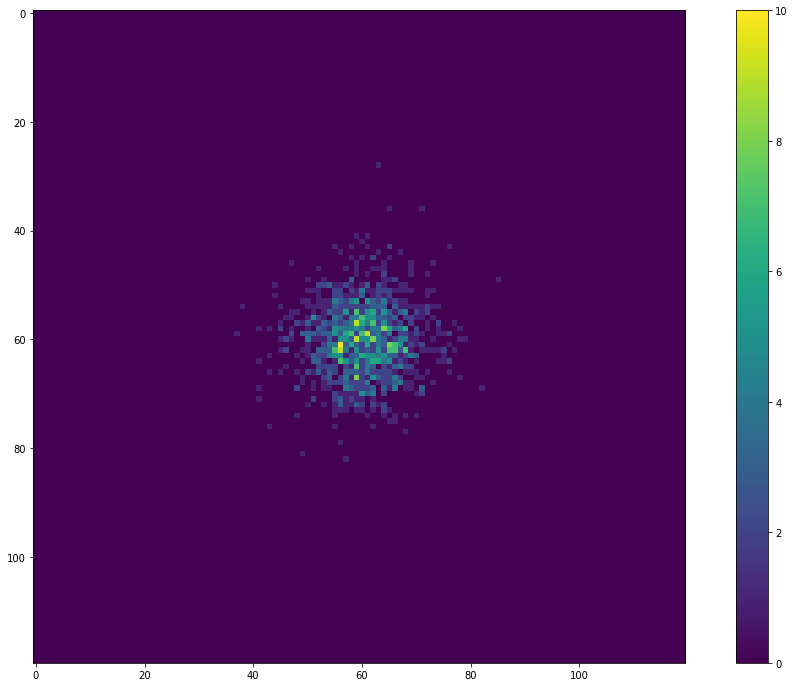

In [8]:
N=60
nu=6
threshold=0.001

filename_strike = f"C:\\Users\\gabri\\Desktop\\Capstone\\data\\x2_widths\\{N}_{nu}_{threshold}_strikedata.txt"
strike_file = open(filename_strike,'r')
strike_data_str = strike_file.read()
strike_data_str = strike_data_str.split('#')[:-1]

strike_data = np.zeros((N*2, N*2))
print("Datapoints:",len(strike_data_str))

for point in strike_data_str:
    point = point.split(',')
    x_coord = point[1]
    y_coord = point[2]
    x_coord = x_coord.strip()
    y_coord = y_coord.strip()
    y_coord = y_coord.strip(')')
    strike_data[int(x_coord), int(y_coord)] += 1

cmap = matplotlib.cm.viridis
fig = plt.figure(figsize=(18,12))
plt.imshow(strike_data, cmap=cmap)
plt.colorbar()
plt.show()